## <b><font color='darkblue'>Preface</font></b>
([source](https://machinelearningmastery.com/document-clustering-with-llm-embeddings-in-scikit-learn/)) <font size='3ptx'><b>In this article, you will learn how to cluster a collection of text documents using large language model embeddings and standard clustering algorithms in [scikit-learn](https://scikit-learn.org/)</b>.

Topics we will cover include:
- Why LLM-based embeddings are well suited for document clustering.
- How to generate embeddings from raw text using a pre-trained sentence transformer.
- How to apply and compare k-means and DBSCAN for clustering embedded documents.

Let’s get straight to the point.
![ui](https://machinelearningmastery.com/wp-content/uploads/2026/01/mlm-chugani-document-clustering-llm-embeddings-feature.jpg)

In [9]:
import os

## <b><font color='darkblue'>Introduction</font></b>
<font size='3ptx'><b>Imagine that you suddenly obtain a large collection of unclassified documents and are tasked with grouping them by topic.</b> There are traditional clustering methods for text, based on [**TF-IDF**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) and [**Word2Vec**](https://en.wikipedia.org/wiki/Word2vec), that can address this problem, but they suffer from important limitations</font>:

* <b>TF-IDF only counts words in a text and relies on similarity based on word frequencies, <font color='red'>ignoring the underlying meaning</font>.</b> A sentence like “the tree is big” has an identical representation whether it refers to a natural tree or a decision tree classifier used in machine learning.
* <b>Word2Vec captures relationships between individual words to form embeddings</b> (<font color='brown'>numerical vector representations</font>), but it does not explicitly model <font color='red'>full context across longer text sequences</font>.

Meanwhile, <b>modern embeddings generated by large language models</b>, such as sentence transformer models, are in most cases superior. They capture contextual semantics — for example, distinguishing natural trees from decision trees — and encode overall, document-level meaning. Moreover, these embeddings are produced by models pre-trained on millions of texts, meaning they already contain a substantial amount of general language knowledge.

This article follows up on a [**previous tutorial**](https://machinelearningmastery.com/feature-engineering-with-llm-embeddings-enhancing-scikit-learn-models/), where we learned how to convert raw text into large language model embeddings that can be used as features for downstream machine learning tasks. <b>Here, we focus specifically on using embeddings from a collection of documents for clustering based on similarity, with the goal of identifying common topics among documents in the same cluster</b>.

## <b><font color='darkblue'>Background - Feature Engineering with LLM Embeddings: Enhancing Scikit-learn Models</font></b>
([source](https://machinelearningmastery.com/feature-engineering-with-llm-embeddings-enhancing-scikit-learn-models/)) <font size='3ptx'><b>Large language model embeddings, or LLM embeddings, are a powerful approach to capturing semantically rich information in text and utilizing it to leverage other machine learning models</b> - like those trained using Scikit-learn — in tasks that require deep contextual understanding of text, such as intent recognition or sentiment analysis.</font>

This article briefly describes what LLM embeddings are and shows how to use them as engineered features for Scikit-learn models.

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import numpy as np

### <b><font color='darkgreen'>What Are LLM Embeddings?</font></b>
<font size='3ptx'><b>LLM embeddings are semantically rich numerical (vector) representations of entire text sequences produced by LLMs.</b> This notion may at first challenge some solidly foundational perceptions about text embeddings and the general purpose of LLMs, so let’s clarify a couple of points to better understand LLM embeddings:</font>

- While “conventional” embeddings — like [**Word2Vec**](https://www.tensorflow.org/text/tutorials/word2vec), [**FastText**](https://fasttext.cc/), etc. — are contextless, <b>fixed vector representations of individual words used as input features for downstream models</b>, <b><font color='green'>LLM embeddings are typically representations of full sequences, such that the meaning of words in the sequence is contextualized</font></b>.
- Although LLMs normally generate text sequences as outputs, some specific models like [**all-miniLM**](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) are specifically designed to produce context-enriched output embeddings, i.e. numerical representations, instead of generating text. As mentioned earlier, these output embeddings have a richer level of semantic information, making them turning them into suitable inputs for downstream models.

![image](https://machinelearningmastery.com/wp-content/uploads/2025/07/LLMembeddings-scaled.png)

### <b><font color='darkgreen'>Using LLM Embeddings in Feature Engineering</font></b>
<font size='3ptx'>The first step to leverage LLM embeddings for feature engineering tasks is to <b>use a suitable LLM like those available at Hugging Face’s `SentenceTransformers` library</b>, for instance, [**`all-MiniLM-L6-v2`**](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2).

The code excerpt below installs and imports the library and uses it to turn a list of text sequences, contained in a dataset attribute, into embedding representations. <b>The dataset, available [here](https://github.com/gakudo-ai/open-datasets/blob/main/customer_support_dataset.csv), describes customer support tickets — enquiries and complaints — belonging to several classes, combining text alongside some structured</b> (<font color='brown'>numerical</font>) <b>customer behavior features</b>.

Let’s focus on <b>turning the raw text feature into LLM embeddings first</b>:

In [10]:
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [13]:
!pip freeze | grep -P '(sentence-transformers|scikit-learn)'

scikit-learn==1.8.0
sentence-transformers==5.2.3


In [4]:
from sentence_transformers import SentenceTransformer
import pandas as pd 

url = "https://raw.githubusercontent.com/gakudo-ai/open-datasets/refs/heads/main/customer_support_dataset.csv"
df = pd.read_csv(url)

# Extract columns
text_data = df["text"].tolist()
structured_data = df[["prior_tickets", "account_age_days"]].values
labels = df["label"].tolist()

model = SentenceTransformer('all-MiniLM-L6-v2')
X_embeddings = model.encode(text_data)

In [17]:
structured_data[:10]

array([[  1, 183],
       [  5, 188],
       [  4, 197],
       [  4, 181],
       [  5,  95],
       [  2, 245],
       [  4, 119],
       [  5, 321],
       [  3, 237],
       [  5,  30]])

Now that we have taken care of the text feature in the dataset, <b>we prepare the two numerical features describing customers: `prior_tickets` and `account_age_days`</b>. If we observe them, we can see they move across pretty different value ranges; hence, it would be a good idea to scale these attributes.

After that, using Numpy’s [hstack()](https://numpy.org/devdocs/reference/generated/numpy.hstack.html) function, both scaled features and LLM embeddings are re-unified:

In [22]:
scaler = StandardScaler()
structured_scaled = scaler.fit_transform(structured_data)
X_combined = np.hstack([structured_scaled, X_embeddings])

Now that this feature engineering process has been completed, <b>all that remains is splitting the engineered dataset containing LLM embeddings into training and test sets, training a Scikit-learn model for customer ticket classification — out of five possible classes — and evaluating it</b>.

In [28]:
%%time
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, labels, test_size=0.2, random_state=42, stratify=labels)

# Train
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     billing       1.00      1.00      1.00         2
         bug       1.00      1.00      1.00         2
    delivery       1.00      1.00      1.00         2
       login       1.00      1.00      1.00         2
      refund       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

CPU times: user 139 ms, sys: 0 ns, total: 139 ms
Wall time: 137 ms


In the above code, the sequence of events is:
1. Splits the unified customer features and associated labels into training examples (80%) and test examples (20%). Using the `stratify=labels` argument here is extremely important, since we are handling a very small dataset; otherwise, the representation of all five classes in both the training and test sets would not be guaranteed
2. Initializes and trains a random forest classifier ([**`RandomForestClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)) with default settings: no specified hyperparameters for the ensemble or its underlying trees
3. Evaluates the trained classifier on the test set.

Based on the classification report, our approach appears to be quite successful. <b>This success is largely thanks to the LLM embeddings, which converted raw text into numerically rich features that captured the semantic intent of the customer tickets.</b> This allowed the Random Forest classifier to distinguish between nuanced requests that would be challenging for simpler text-representation methods.

<b>To truly quantify the value added, a crucial next step would be to establish a baseline by comparing these results against a model trained with traditional features like TF-IDF. Further improvements could also be explored by tuning the classifier’s hyperparameters or applying this technique to a larger, more robust dataset to confirm its effectiveness.</b> Nonetheless, this experiment serves as a powerful proof of concept, clearly demonstrating how LLM embeddings can be seamlessly integrated to boost the performance of Scikit-learn models on text-heavy tasks.

## <b><font color='darkblue'>Step-by-Step Guide</font></b>
<b><font size='3ptx'>Let’s walk through the full process using Python.</font></b>

### <b><font color='darkgreen'>Step-0: Importing</font></b>
<font size='3ptx'><b>Depending on your development environment or notebook configuration, you may need to `pip install` some of the libraries imported below.</b> Assuming they are already available, we start by importing the required modules and classes, including KMeans, scikit-learn’s implementation of the k-means clustering algorithm</font>:

In [33]:
!pip freeze | grep -P '(matplotlib|numpy|sentence_transformers|scikit-learn|seaborn)'

matplotlib==3.10.8
matplotlib-inline==0.1.7
numpy==2.3.2
scikit-learn==1.8.0
seaborn==0.13.2


In [34]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
 
# Configurations for clearer visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### <b><font color='darkgreen'>Step-1: Load dataset</font></b>
Next, we load the dataset. We will <b>use a BBC News dataset containing articles labeled by topic, with a public version available from a Google-hosted dataset repository</b>:

In [36]:
url = "https://raw.githubusercontent.com/mdsohaib/BBC-News-Classification/refs/heads/master/bbc-text.csv"
df = pd.read_csv(url)

print(f"Dataset loaded: {len(df)} documents")
print(f"Categories: {df['category'].unique()}\n")
print(df['category'].value_counts())

Dataset loaded: 2225 documents
Categories: ['tech' 'business' 'sport' 'entertainment' 'politics']

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


Here, we only display information about the categories to get a sense of the ground-truth topics assigned to each document. The dataset contains 2,225 documents in the version used at the time of writing.

<b>At this point, we are ready for the two main steps of the workflow: generating embeddings from raw text and clustering those embeddings.</b>

### <b><font color='darkgreen'>Step-2: Generating Embeddings with a Pre-Trained Model</font></b>
<b><font size='3ptx'>Libraries such as [sentence_transformers](https://pypi.org/project/sentence-transformers/) make it straightforward to use a pre-trained model for tasks like generating embeddings from text.</font></b>

The workflow consists of loading a suitable model — such as [**all-MiniLM-L6-v2**](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2), **a lightweight model trained to produce 384-dimensional embeddings — and running inference over the dataset to convert each document into a numerical vector that captures its overall semantics.**

We start by loading the model:

In [37]:
# Load embeddings model (downloaded automatically on first use)
print("Loading embeddings model...")
model = SentenceTransformer('all-MiniLM-L6-v2')

# This model converts text into a 384-dimensional vector
print(f"Model loaded. Embedding dimension: {model.get_sentence_embedding_dimension()}")

Loading embeddings model...
Model loaded. Embedding dimension: 384


Next, we generate embeddings for all documents:

In [38]:
# Convert all documents into embedding vectors
print("Generating embeddings (this may take a few minutes)...")

texts = df['text'].tolist()
embeddings = model.encode(
    texts,
    show_progress_bar=True,
    batch_size=32  # Batch processing for efficiency
)

print(f"Embeddings generated: matrix size is {embeddings.shape}")
print(f"   → Each document is now represented by {embeddings.shape[1]} numeric values")

Generating embeddings (this may take a few minutes)...


Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [01:10<00:00,  1.01s/it]

Embeddings generated: matrix size is (2225, 384)
   → Each document is now represented by 384 numeric values


Recall that an embedding is a high-dimensional numerical vector. Documents that are semantically similar are expected to have embeddings that are close to each other in this vector space.

### <b><font color='darkgreen'>Step-3: Clustering Document Embeddings with K-Means</font></b>
<b><font size='3ptx'>Applying the [**k-means clustering**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) algorithm with scikit-learn is straightforward.</font></b>

<b>We pass in the embedding matrix and specify the number of clusters to find. While this number must be chosen in advance for k-means, we can leverage prior knowledge of the dataset’s ground-truth categories in this example.</b> In other settings, techniques such as the elbow method can help guide this choice.

The following code applies k-means and evaluates the results using several metrics, including the [**Adjusted Rand Index**](https://en.wikipedia.org/wiki/Rand_index) (ARI). ARI is a permutation-invariant metric that compares the cluster assignments with the true category labels. <b>Values closer to 1 indicate stronger agreement with the ground truth</b>.

In [41]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(embeddings)

# Evaluation against ground-truth categories
le = LabelEncoder()
true_labels = le.fit_transform(df['category'])

print("   K-Means Results:")
print(f"   Silhouette Score: {silhouette_score(embeddings, kmeans_labels):.3f}")
print(f"   Adjusted Rand Index: {adjusted_rand_score(true_labels, kmeans_labels):.3f}")
print(f"   Distribution: {pd.Series(kmeans_labels).value_counts().sort_index().tolist()}")

   K-Means Results:
   Silhouette Score: 0.066
   Adjusted Rand Index: 0.899
   Distribution: [376, 414, 517, 497, 421]


### <b><font color='darkgreen'>Step-4: Clustering Document Embeddings with DBSCAN</font></b>
<font size='3ptx'><b>As an alternative, we can apply [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), a density-based clustering algorithm that automatically infers the number of clusters based on point density.</b> Instead of specifying the number of clusters, [**DBSCAN**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) requires parameters such as `eps` (<font color='brown'>the neighborhood radius</font>) and `min_samples`:</font>

DBSCAN is highly sensitive to its hyperparameters, so achieving good results often requires careful tuning using systematic search strategies.

In [43]:
from sklearn.cluster import DBSCAN

# DBSCAN often works better with cosine distance for text embeddings
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
dbscan_labels = dbscan.fit_predict(embeddings)

# Count clusters (-1 indicates noise points)
n_clusters_found = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print("\nDBSCAN Results:")
print(f"   Clusters found: {n_clusters_found}")
print(f"   Noise documents: {n_noise}")
print(f"   Silhouette Score: {silhouette_score(embeddings[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]):.3f}")
print(f"   Adjusted Rand Index: {adjusted_rand_score(true_labels, dbscan_labels):.3f}")
print(f"   Distribution: {pd.Series(dbscan_labels).value_counts().sort_index().to_dict()}")


DBSCAN Results:
   Clusters found: 6
   Noise documents: 400
   Silhouette Score: -0.028
   Adjusted Rand Index: 0.035
   Distribution: {-1: 400, 0: 1798, 1: 9, 2: 5, 3: 5, 4: 5, 5: 3}


### <b><font color='darkgreen'>Step-5: Visualization</font></b>
<font size='3ptx'>Once reasonable parameters have been identified, it can be informative to visually compare the clustering results. <b>The following code projects the embeddings into two dimensions using [principal component analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (PCA) and plots the true categories alongside the [k-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) cluster assignments</b></font>:

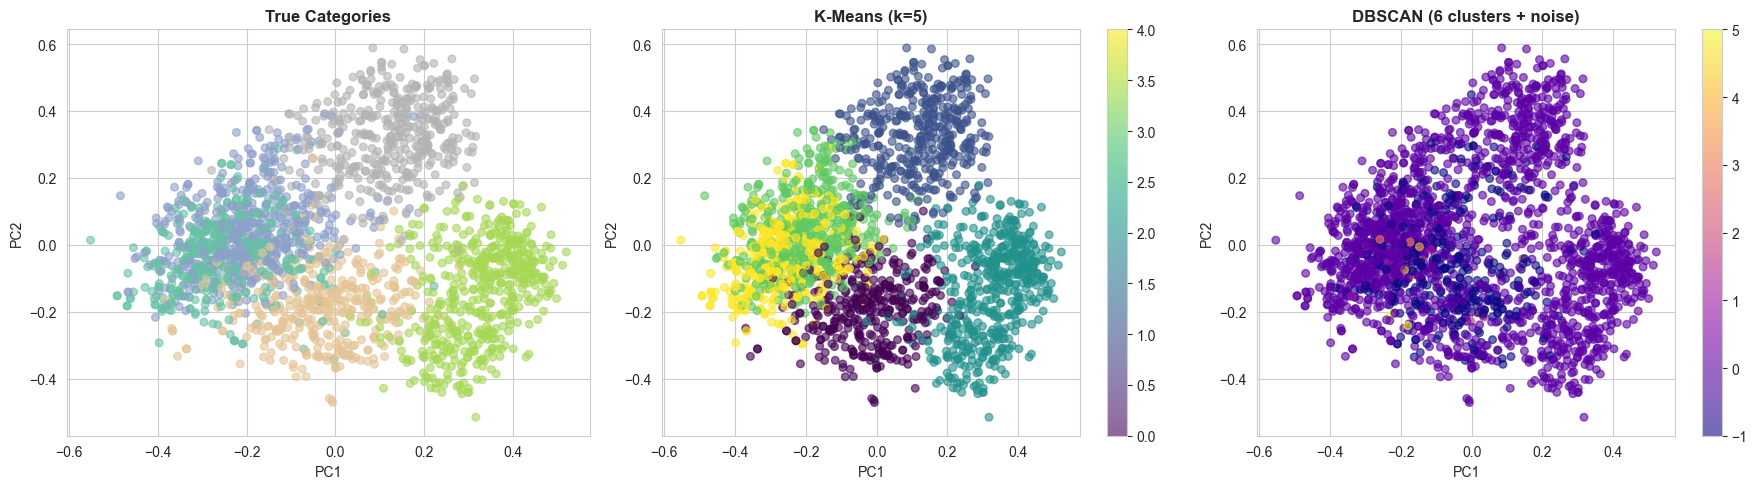

In [44]:
# Reduce embeddings to 2D for visualization
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

# Create comparative visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: True categories
category_colors = {cat: i for i, cat in enumerate(df['category'].unique())}
color_map = df['category'].map(category_colors)

axes[0].scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=color_map,
    cmap='Set2',
    alpha=0.6,
    s=30
)
axes[0].set_title('True Categories', fontsize=12, fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

# Plot 2: K-Means
scatter2 = axes[1].scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=kmeans_labels,
    cmap='viridis',
    alpha=0.6,
    s=30
)
axes[1].set_title(f'K-Means (k={n_clusters})', fontsize=12, fontweight='bold')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
plt.colorbar(scatter2, ax=axes[1])

# Plot 3: DBSCAN
scatter3 = axes[2].scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=dbscan_labels,
    cmap='plasma',
    alpha=0.6,
    s=30
)
axes[2].set_title(f'DBSCAN ({n_clusters_found} clusters + noise)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
plt.colorbar(scatter3, ax=axes[2])

plt.tight_layout()
plt.show()

With the default DBSCAN settings, k-means typically performs much better on this dataset. There are two main reasons for this:
* **DBSCAN suffers from the curse of dimensionality**, and 384-dimensional embeddings can be challenging for density-based methods.
* **K-means performs well when clusters are relatively well separated**, which is the case for the BBC News dataset due to the clear topical structure of the documents.

## <b><font color='darkblue'>Wrapping Up</font></b>
In this article, we demonstrated how to cluster a collection of text documents using embedding representations generated by pre-trained large language models. After transforming raw text into numerical vectors, we applied traditional clustering techniques — k-means and DBSCAN — to group semantically similar documents and evaluate their performance against known topic labels.